In [16]:
import numpy as np

In [17]:
M = 20  # kg
g = 9.8 # m / s^2
m = 0.5 # kg
l = 0.5 # m

In [18]:
v1 = ((M + m) * g) / (M * l)
v2 = -(m * g) / M

c1 = -1 / (M * l)
c2 = 1 / M

In [19]:
A = np.array([[0, 1, 0, 0], [0, 0, v2, 0], [0, 0, 0, 1], [0, 0, v1, 0]])
B = np.array([[0], [c2], [0], [c1]])

In [20]:
print(np.shape(A))
print(np.shape(B))

(4, 4)
(4, 1)


## Controllability

CM = [B AB A<sup>2</sup>B A<sup>3</sup>B]

In [21]:
CM = np.array([[B], [A @ B], [A @ A @ B], [A @ A @ A @ B]]).reshape(4, 4)

In [22]:
print((CM))

[[ 0.      0.05    0.     -0.1   ]
 [ 0.05    0.     -0.1     0.    ]
 [ 0.      0.0245  0.     -2.009 ]
 [ 0.0245  0.     -2.009   0.    ]]


In [23]:
rank = np.linalg.matrix_rank(CM)
print("Rank of CM: ", rank)

Rank of CM:  4


> Rank of CM = 4, therefore controllable

## Stability


In [24]:
print(A)

[[ 0.     1.     0.     0.   ]
 [ 0.     0.    -0.245  0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.     0.    20.09   0.   ]]


In [25]:
eigenvalues = np.linalg.eigvals(A)

print("Eigenvalues of matrix A:", eigenvalues)

Eigenvalues of matrix A: [ 0.          0.          4.48218697 -4.48218697]


>One eigen value is positive, so the system is unstable

## Value Iteration


In [26]:
Q = np.diag([100, 100, 1, 1])
R = np.array([[0.1]])


In [27]:
print("A:\n", A)
print("B:\n", B)

A:
 [[ 0.     1.     0.     0.   ]
 [ 0.     0.    -0.245  0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.     0.    20.09   0.   ]]
B:
 [[ 0.  ]
 [ 0.05]
 [ 0.  ]
 [-0.1 ]]


In [28]:
import control
# Define the desired closed-loop poles
desired_poles = np.array([ -0.1 , 9.63 ,-0.058, -4.48])

# Compute the feedback gain matrix F that places the closed-loop poles at the desired locations
F = control.place(A, B, desired_poles)

# Check if the closed-loop system is stable
if np.all(np.real(np.linalg.eigvals(A + B @ F)) < 0):
    print("Closed-loop system is stable")
else:
    print("Closed-loop system is unstable")


Closed-loop system is stable


In [29]:
print(F)

[[  0.25533257   6.98609102 238.73066629  53.41304551]]


In [31]:
def value_iteration(A, B, Q, R, F):
    # solve for P
    # some random positive P0
    P0 = np.array([[   4.20142881,    8.32600202,   32.36519315,    7.32527867],
               [   8.32600202,   31.67853401,  128.65477625,   29.12535147],
               [  32.36519315,  128.65477625, 2355.4036579,   523.25286389],
               [   7.32527867,   29.12535147,  523.25286389,  116.91040301]])

    P = P0.copy()


    max_iter = 1

    for i in range(max_iter):
        # print current iteration
        print("Iteration: ", i)
        # solve for P(i + 1) , P(i + 1) = Q + F.T @ R @ F + (A + B @ F).T @ Pi @ (A + B @ F) + F.T @ B.T @ Pi @ (A + B @ F) + (A + B @ F).T @ Pi @ B @ F in a loop
        P_new = Q + F.T @ R @ F + (A + B @ F).T @ P @ (A + B @ F) + F.T @ B.T @ P @ (A + B @ F) + (A + B @ F).T @ P @ B @ F
        P = P_new.copy()
        
        F = -np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

        print("P", P)
        print("F", F)
    
    

    return F

 
F = value_iteration(A, B, Q, R, F)

print("F", F)

Iteration:  0
P [[  100.             0.             0.             0.        ]
 [    0.           104.20142881    18.54622787    32.36277856]
 [    0.            18.54622787  1565.8915177  -7888.40601062]
 [    0.            32.36277856 -7888.40601062  2355.70286516]]
F [[  0.           0.         199.22867098 -33.47338778]]
F [[  0.           0.         199.22867098 -33.47338778]]


In [32]:
print("Eigenvalues of A + BF:", np.linalg.eigvals(A + B @ F))

Eigenvalues of A + BF: [ 0.          0.         -0.04920673  3.39654551]


In [33]:
import control
# Define the desired closed-loop poles
desired_poles = np.array([ 0. , 9.63475861 ,-0.05825404, -4.48258043])

# Compute the feedback gain matrix F that places the closed-loop poles at the desired locations
F = control.place(A, B, desired_poles)

# Check if the closed-loop system is stable
if np.all(np.real(np.linalg.eigvals(A + B @ F)) < 0):
    print("Closed-loop system is stable")
else:
    print("Closed-loop system is unstable")

Closed-loop system is stable


In [34]:
import cv2

class InvertedPendulum:
    def __init__(self):
        f = 0

    def step( self, state_vec, t=None ):
        """ state vector :
                x0 : position of the cart
                x1 : veclocity of the cart
                x2 : angle of pendulum. In ref frame with x as forward of the cart and y as up. Angile with respect to ground plane
                x3 : angular velocity of the pendulum
        """
        CART_POS = state_vec[0]
        BOB_ANG  = state_vec[2]*180. / np.pi  # degrees
        # subtract bob angle from 90 to get angle wrt vertical
        LENGTH_OF_PENDULUM = 110.

        # IM = np.zeros( (512, 512,3), dtype='uint8' )
        IM = cv2.imread('imgs/background.jpg')
        IM = cv2.resize( IM, (512,512) )

        # Ground line
        cv2.line(IM, (0, 450), (IM.shape[1], 450), (0,0,40), 4 )


        # Mark ground line
        XSTART = -30.
        XEND = 5.
        for xd in np.linspace( XSTART, XEND, 11 ):
            x = int(   (xd - XSTART) / (XEND - XSTART) * IM.shape[0]   )

            cv2.circle( IM, (x, 450), 5, (255,0,255), -1 )

            cv2.putText(IM, str(xd), (x-15,450+15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (255, 255, 200), 1)


        # Draw Wheels of the cart
        wheel_1_pos = int(   (CART_POS - 3 - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        wheel_2_pos = int(   (CART_POS + 3 - XSTART) / (XEND - XSTART) * IM.shape[0]   )

        cv2.circle( IM, (wheel_1_pos, 415), 25, (0,255,255), 6 )
        cv2.circle( IM, (wheel_2_pos, 415), 25, (0,255,255), 6 )
        cv2.circle( IM, (wheel_1_pos, 415), 2, (0,255,255), -1 )
        cv2.circle( IM, (wheel_2_pos, 415), 2, (0,255,255), -1 )

        # Cart base
        cart_base_start = int(   (CART_POS - 4 - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        cart_base_end   = int(   (CART_POS + 4 - XSTART) / (XEND - XSTART) * IM.shape[0]   )

        cv2.line( IM, (cart_base_start, 380), (cart_base_end, 380), (255,10,200), 6 )

        # Pendulum hinge
        pendulum_hinge_x = int(   (CART_POS - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        pendulum_hinge_y = 380
        cv2.circle( IM, (pendulum_hinge_x, pendulum_hinge_y), 10, (200,150,10), -1 )


        # Pendulum
        pendulum_bob_x = int( LENGTH_OF_PENDULUM * np.cos( BOB_ANG / 180. * np.pi ) )
        pendulum_bob_y = int( LENGTH_OF_PENDULUM * np.sin( BOB_ANG / 180. * np.pi ) )
        cv2.circle( IM, (pendulum_hinge_x+pendulum_bob_x, pendulum_hinge_y-pendulum_bob_y), 10, (255,100,255), -1 )
        cv2.line( IM, (pendulum_hinge_x, pendulum_hinge_y), (pendulum_hinge_x+pendulum_bob_x, pendulum_hinge_y-pendulum_bob_y), (100,200,255), 3 )

        # Mark the current angle
        angle_display = BOB_ANG % 360
        if( angle_display > 180 ):
            angle_display = -360+angle_display
        cv2.putText(IM, "theta="+str( np.round(angle_display,4) )+" deg", (pendulum_hinge_x-15, pendulum_hinge_y-15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1)


        # Display on top
        if t is not None:
            cv2.putText(IM, "t="+str(np.round(t,4))+"sec", (15, 15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,0), 1)
            cv2.putText(IM, "ANG="+str(np.round((BOB_ANG),4))+" degrees", (15, 35), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,0), 1)
            cv2.putText(IM, "POS="+str(np.round(CART_POS,4))+" m", (15, 55), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,0), 1)

        return IM

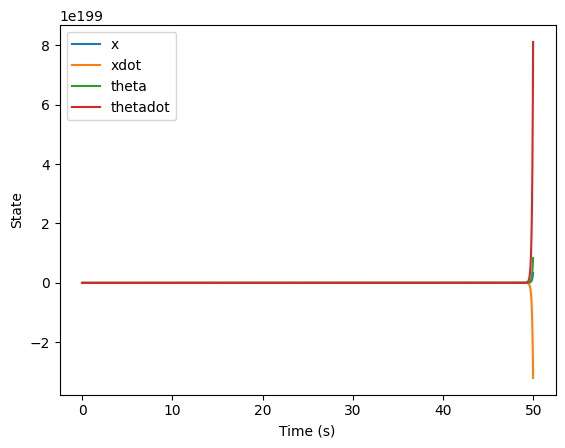

In [38]:
# import continuous_are from scipy
from scipy.linalg import solve_continuous_are

theta_0 = np.pi/6

# Define the state vector x and the control input u
x = np.array([[0], [0], [theta_0], [0]])
u = 0

# Define the cost function weights Q and R
Q = np.diag([100, 100, 1, 1])   # higher weight on theta for control input stability
R = np.array([[0.1]])

# Compute the optimal gain matrix K using the ARE
P = solve_continuous_are(A, B, Q, R) # solves the continuous algebraic Riccati equation
K = np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)

# Simulate the system with the computed gain matrix K
t0, tf = 0, 50    # initial and final simulation time
dt = 0.01     # time step
t = np.arange(t0, tf, dt)
x_history = np.zeros((4, len(t)))
x_history[:, 0] = x[:, 0]
U = []

for i in range(1, len(t)):
    # Compute the control input using the optimal gain matrix K
    u = -F @ x
    U.append(u)

    # Update the state using the system dynamics
    x_dot = A @ x + B @ u
    
    x[0] = x[0] - x_dot[0] * dt
    x[1] = x[1] + x_dot[1] * dt
    x[2] = x[2] + x_dot[2] * dt
    x[3] = x[3] + x_dot[3] * dt

    # Save the state history
    x_history[:, i] = x[:, 0]

# Plot the state history
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t, x_history[0, :], label='x')
plt.plot(t, x_history[1, :], label='xdot')
plt.plot(t, x_history[2, :], label='theta')
plt.plot(t, x_history[3, :], label='thetadot')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.show()

In [39]:
# print eig values of A + BF
print("Eigen values of A + BF", np.linalg.eigvals(A + B @ F))

Eigen values of A + BF [-3.37507799e-14+0.j         -4.48081445e+00+0.j
 -3.06554846e-01+0.68374626j -3.06554846e-01-0.68374626j]


In [40]:
# append 0 to first element of U
U = np.insert(U, 0, 0)
U = np.array(U).reshape(5000, 1)

print(F)

X = x_history

U = U.reshape(5000, )
X = np.array(X).reshape(4, 5000)
x1 = X[0].reshape(5000, )
x2 = X[1].reshape(5000, )
x3 = X[2].reshape(5000, )
x4 = X[3].reshape(5000, )

print(np.shape(U))
print(np.shape(x1))

[[8.68269917e-14 2.56725438e+00 2.33987156e+02 5.22228686e+01]]
(5000,)
(5000,)


In [41]:
import pandas as pd

df = pd.DataFrame({'x': x1, 'xdot': x2, 'theta': x3, 'thetadot': x4, 'u': U}, )
# print df with style
# print(df)
print(min(U))
df

-5.584128300157915e+201


,x,xdot,theta,thetadot,u
0,0.000000e+00,0.000000e+00,5.235988e-01,0.000000e+00,0.000000e+00
1,0.000000e+00,-6.254051e-02,5.235988e-01,2.277064e-01,-1.225154e+02
2,6.254051e-04,-1.309465e-01,5.258758e-01,4.671437e-01,-1.342463e+02
3,1.934870e-03,-2.057887e-01,5.305473e-01,7.198997e-01,-1.471076e+02
4,3.992757e-03,-2.876926e-01,5.377463e-01,9.876949e-01,-1.612082e+02
...,...,...,...,...,...
4995,2.297813e+198,-2.213888e+199,5.825669e+198,5.612892e+199,-3.865114e+201
4996,2.519202e+198,-2.427190e+199,6.386958e+198,6.153680e+199,-4.237509e+201
4997,2.761921e+198,-2.661044e+199,7.002326e+198,6.746572e+199,-4.645782e+201
4998,3.028025e+198,-2.917429e+199,7.676984e+198,7.396588e+199,-5.093392e+201


In [42]:
syst = InvertedPendulum()

for i in range(len(X[0])):
    rendered = syst.step( [X[0][i], X[1][i], X[2][i] + np.pi/2, X[3][i]], t=i*0.01)
    cv2.imshow( 'im', rendered )

    # Press q to exit

    if cv2.waitKey(5) == ord('q'):
        break

cv2.destroyAllWindows()

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type


In [43]:
cv2.destroyAllWindows()

